In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
import string
import re
from nltk.corpus import stopwords
import cv2
import nltk

## EDA

In [2]:
import pandas as pd
import os

# Load caption data
captions_file = '/Users/tanujverma/Desktop/archive/captions.txt'
captions_df = pd.read_csv(captions_file)
num_captions = len(captions_df)


# Count number of images in directory
images_dir = '/Users/tanujverma/Desktop/archive/Images/'
num_images_directory = len([name for name in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, name))])


print('Number of images in directory:', num_images_directory)
print('Number of captions:', num_captions)

Number of images in directory: 8091
Number of captions: 40455


#Caption Analysis

In [3]:
import nltk
nltk.download('punkt')
captions_df['caption_tokens'] = captions_df['caption'].apply(nltk.word_tokenize)

# Count the number of words in each caption
captions_df['caption_length'] = captions_df['caption_tokens'].apply(len)

# Count the number of unique words in the captions
captions_df['unique_words'] = captions_df['caption_tokens'].apply(set).apply(len)

# Display the DataFrame with columns
print(captions_df[['image', 'caption', 'caption_length', 'unique_words']].head(5))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanujverma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  caption_length  \
0  A child in a pink dress is climbing up a set o...              18   
1              A girl going into a wooden building .               8   
2   A little girl climbing into a wooden playhouse .               9   
3  A little girl climbing the stairs to her playh...              10   
4  A little girl in a pink dress going into a woo...              13   

   unique_words  
0            16  
1             8  
2             9  
3            10  
4            12  


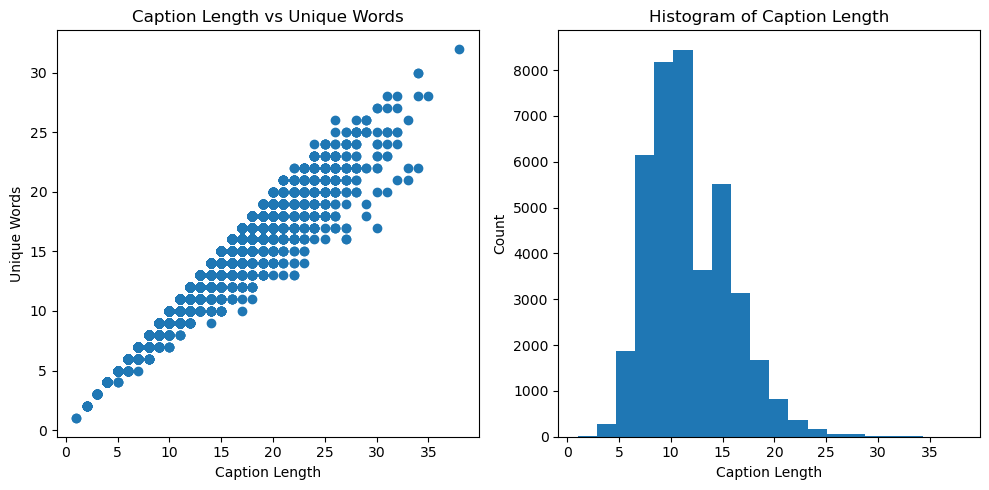

In [4]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot - Scatter plot
x = captions_df['caption_length']
y = captions_df['unique_words']
ax1.scatter(x, y)
ax1.set_xlabel('Caption Length')
ax1.set_ylabel('Unique Words')
ax1.set_title('Caption Length vs Unique Words')

# Second subplot - Histogram
caption_lengths = captions_df['caption_length']
ax2.hist(caption_lengths, bins=20)
ax2.set_xlabel('Caption Length')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of Caption Length')

plt.tight_layout()
plt.show()


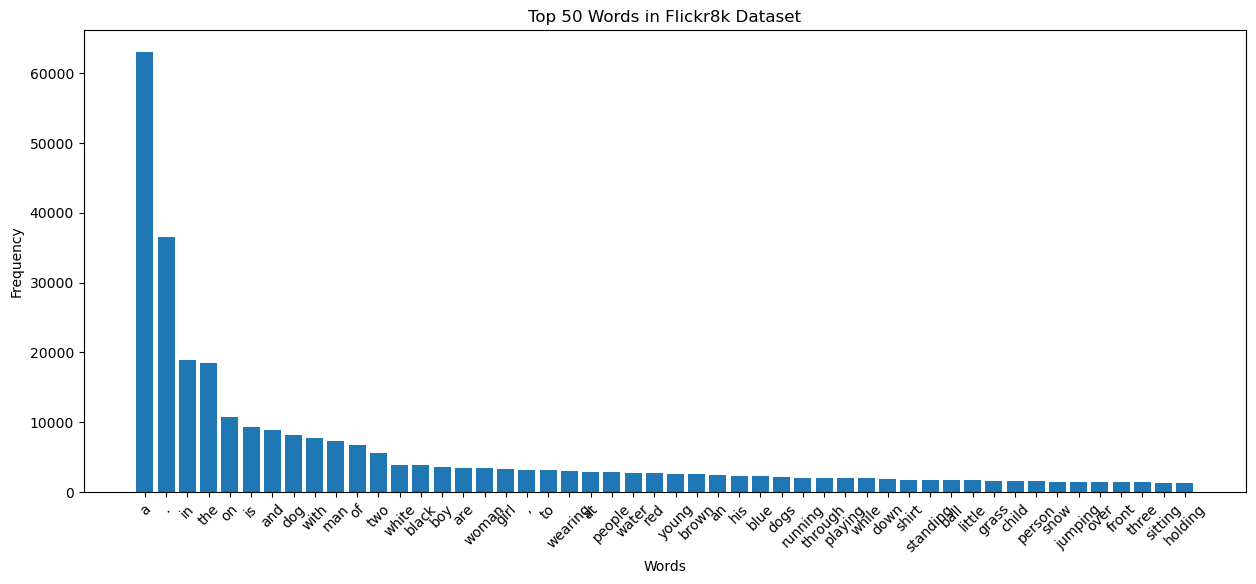

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

# Load the captions file, assuming it is a .txt file with 'image_id#caption_number' and 'caption' columns
captions_file = '/Users/tanujverma/Desktop/archive/captions.txt'
captions_df = pd.read_csv(captions_file)

# Tokenize and count words
all_words = []
for index, row in captions_df.iterrows():
    tokens = word_tokenize(row['caption'].lower())
    all_words.extend(tokens)

word_counts = Counter(all_words)

# Get the top 50 most common words
top_50_words = word_counts.most_common(50)

# Plot the distribution
labels, values = zip(*top_50_words)
plt.figure(figsize=(15, 6))
plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words in Flickr8k Dataset')
plt.xticks(rotation=45)
plt.show()


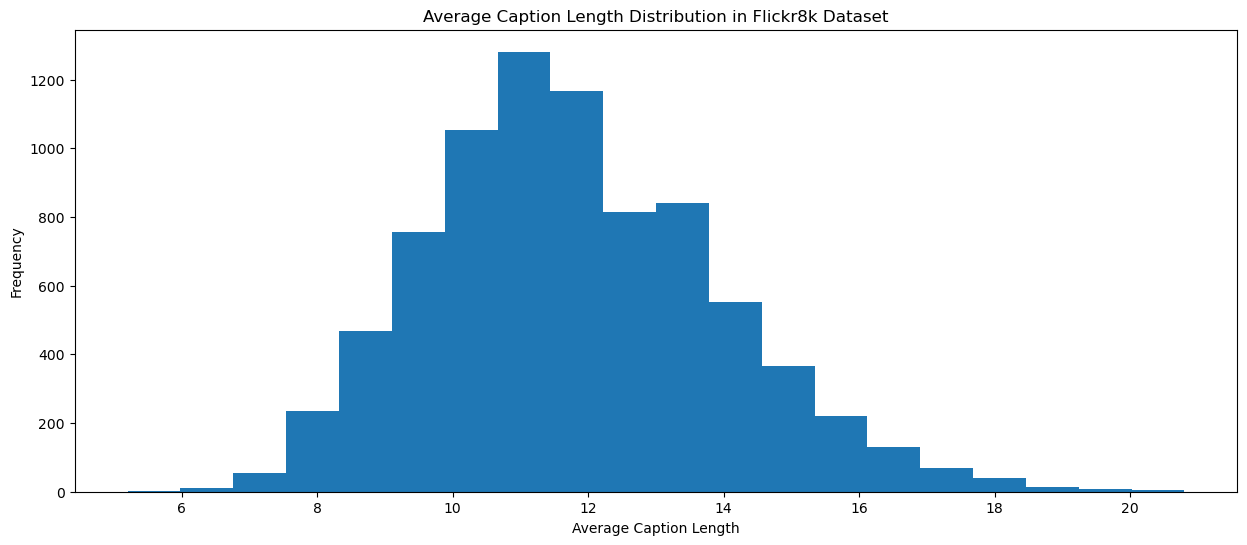

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import word_tokenize

# Load the captions file from the specified path
captions_file = '/Users/tanujverma/Desktop/archive/captions.txt'
captions_df = pd.read_csv(captions_file)

# Calculate caption lengths for each image
caption_lengths = defaultdict(list)
for index, row in captions_df.iterrows():
    image_id = row['image']
    tokens = word_tokenize(row['caption'].lower())
    caption_lengths[image_id].append(len(tokens))

# Calculate average caption length per image
average_caption_lengths = {key: sum(value) / len(value) for key, value in caption_lengths.items()}

# Plot the distribution of average caption lengths
plt.figure(figsize=(15, 6))
plt.hist(average_caption_lengths.values(), bins=20)
plt.xlabel('Average Caption Length')
plt.ylabel('Frequency')
plt.title('Average Caption Length Distribution in Flickr8k Dataset')
plt.show()


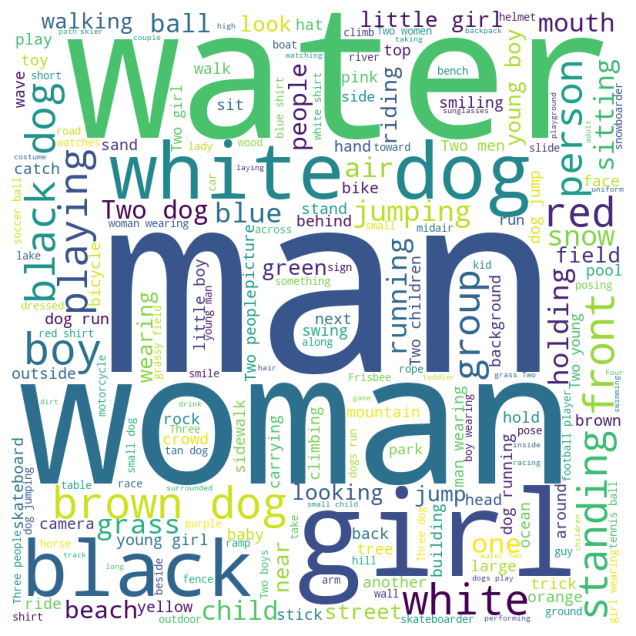

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(captions_df['caption'].tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


#Show image with captions

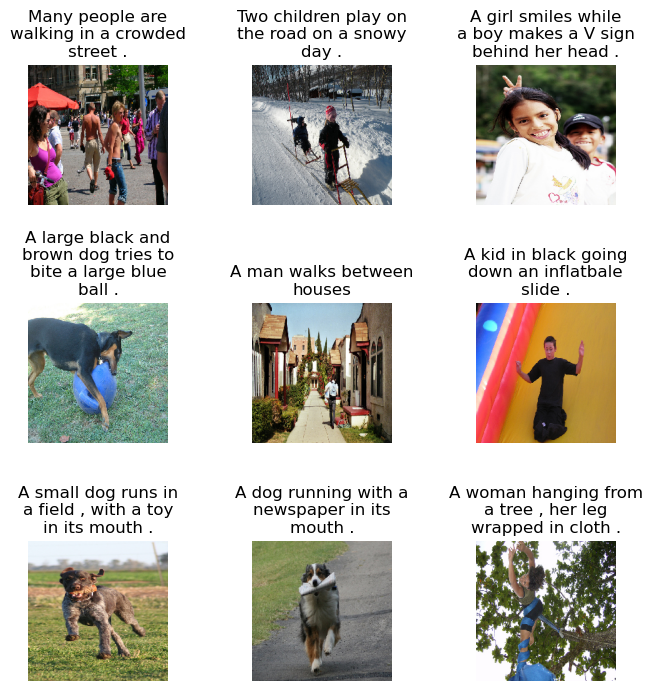

In [8]:
from textwrap import wrap
# To read and display Image data
def read_img(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255
    return img 

def display_images(temp_df, num_images):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (8,8))
    n = 0
    
    for i in range(num_images):
        n += 1
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        path = images_dir + '/' + temp_df.image[i]
        image = read_img(path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')

        
## Display sample image with associated captions 
display_images(captions_df.sample(9), 9)

#Image Analysis

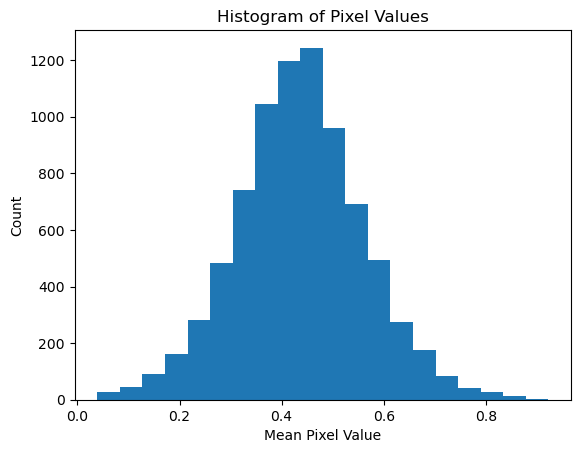

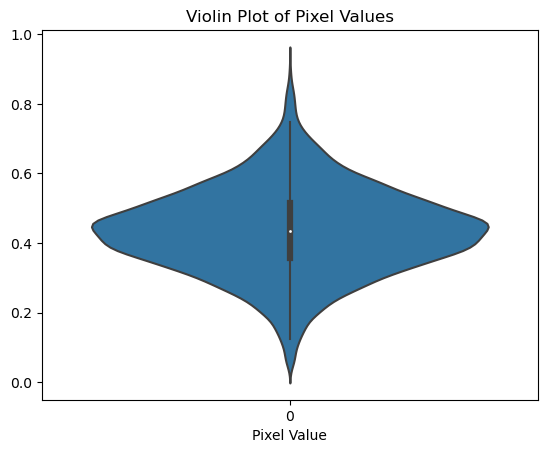

In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to the directory containing the images
image_dir = '/Users/tanujverma/Desktop/archive/Images/'

# Get a list of all the image filenames in the directory
image_files = os.listdir(image_dir)

# Compute the mean pixel value for each image
image_means = []
for image_file in image_files:
    img = Image.open(os.path.join(image_dir, image_file))
    img_array = np.array(img) / 255.0
    mean = np.mean(img_array)
    image_means.append(mean)

# Create a histogram of pixel values
plt.hist(image_means, bins=20)
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')
plt.title('Histogram of Pixel Values')
plt.show()


# Create a violin plot of pixel values
sns.violinplot(image_means)
plt.xlabel('Pixel Value')
plt.title('Violin Plot of Pixel Values')
plt.show()
